# Imports

In [1]:
import torch
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset
import ipywidgets as widgets
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from pysentimiento.preprocessing import preprocess_tweet
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

import unicodedata

2024-05-01 10:49:23.863132: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 10:49:24.057285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 10:49:24.057355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 10:49:24.088748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 10:49:24.155090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [2]:
#pip install torch==2.0.0
#pip install pysentimiento==0.7.2
#pip install evaluate==0.4.0
#pip install datasets==2.14.5
#!pip install unidecode

In [3]:
#!pip install pysentimiento transformers datasets accelerate evaluate

In [87]:
pd.set_option("max_colwidth", 300)

> Three versions of RoBERTuito were trained: a cased version which preserves the case found in the original tweets, an uncased version, and a deacc version, which lower-cases and removes accents on tweets.

In [5]:
max_length = 128
model_name = "pysentimiento/robertuito-base-deacc"

# Helper Functions

In [7]:
def remove_accents(text):
    return ''.join((c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'))

In [8]:
# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

## Load Dataset

In [9]:
# ds = load_dataset("pyupeu/social-media-peruvian-sentiment")
# ds
data_files = {"train": "data/train.csv", "validation": "data/val.csv", "test": "data/test.csv"}
ds = load_dataset("csv", data_files=data_files)

## Performance Metrics

In [10]:
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

def compute_metrics (eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis = -1)
    
    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="macro"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="macro"))
    return results

In [11]:
ds["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_name': Value(dtype='string', id=None),
 'text_original': Value(dtype='string', id=None),
 'tokenized_text': Value(dtype='string', id=None),
 'sent_token_length': Value(dtype='int64', id=None),
 'sent_bert_token_length': Value(dtype='int64', id=None),
 'char_count': Value(dtype='int64', id=None),
 'Character Count': Value(dtype='int64', id=None)}

In [12]:
ds["test"]["label"][:10]

[1, 0, 2, 0, 1, 1, 1, 1, 2, 1]

In [13]:
df = ds['train'].to_pandas()
df.head()

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count
0,renzo crispin javier güere baluarte se pasaron de burros 🤣,0,Negative,Renzo Crispin Javier Güere Baluarte se pasaron de burros 🤣,renzo crispin javier güere baluarte se pasaron de burros 🤣,10,15,58,58
1,chino risas pa que llevas a tus maleteros 🤡🤡🤡,0,Negative,chino risas pa que llevas a tus maleteros 🤡🤡🤡,chino risas pa que llevas a tus maleteros 🤡🤡🤡,9,10,45,45
2,estudia p chato 😵‍💫🙈,0,Negative,Estudia p chato 😵‍💫🙈,estudia p chato 😵‍💫🙈,4,4,20,20
3,"no seas pendejo, jaja tatuaje borra entonces... 😂",0,Negative,"No seas pendejo, jajajajaja tatuaje borra entonces... 😂",no seas pendejo jaja tatuaje borra entonces 😂,8,9,49,49
4,todas las autoridades y las actuales son culpables que kuelap se encuentre en esta situación. son una tira de incapaces 😡,0,Negative,Todas las autoridades y las actuales son culpables que Kuelap se encuentre en esta situación. Son una tira de incapaces 😡,todas las autoridades y las actuales son culpables que kuelap se encuentre en esta situación son una tira de incapaces 😡,21,23,121,121


## Model and Tokenizer

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = max_length

/home/darkstar/anaconda3/envs/robertuito-env/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Pre processing

In [15]:
# encode label and mapping label name
#df["label"] = df["label"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

# remove accents
df["text"] = df["text"].apply(lambda x: remove_accents(x))
df.sample(10)

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count
970,te perdono la japeruana todos cometemos errores asi que la gente que te esta criticando no hagas caso aparte no es bueno vivir amargandose la vida lo pasado pisado.😁,1,Neutral,Te perdono La Japeruana todos cometemos errores asi que la gente que te esta criticando no hagas caso aparte no es bueno vivir amargandose la vida lo pasado pisado.😁,te perdono la japeruana todos cometemos errores asi que la gente que te esta criticando no hagas caso aparte no es bueno vivir amargandose la vida lo pasado pisado 😁,29,35,165,165
3391,con un aguja los destruyo!!😌🤣,0,Negative,Con un aguja los destruyo!!😌🤣,con un aguja los destruyo 😌🤣,5,9,30,30
7056,tabata eguiluz ahora toca su pisquitoo😊 falta el anticucho que tu papaa lo prepareee 😀,1,Neutral,Tábata Eguiluz ahora toca su pisquitoo😊 Falta el anticucho que tu papaa lo prepareee 😀,tábata eguiluz ahora toca su pisquitoo😊 falta el anticucho que tu papaa lo prepareee 😀,15,25,86,86
232,jaja asuuu un paro cumbiambero!!! 💃🤣,0,Negative,Jajaja asuuu un paro cumbiambero!!! 💃🤣,jaja asuuu un paro cumbiambero 💃🤣,6,10,36,36
4310,ya no deberia ser la gordita sexi ahora deberia ser la gordita traca jaja siempre se le pegan los platinos 🤣🤣🤣,0,Negative,Ya no debería ser la gordita sexi ahora debería ser la gordita traca jajaja siempre se le pegan los platinos 🤣🤣🤣,ya no debería ser la gordita sexi ahora debería ser la gordita traca jaja siempre se le pegan los platinos 🤣🤣🤣,21,24,110,110
182,x lo menos no soy la unica q no ve los comentarios de ninguna publicacion 😪 ... ya iba a tirar mi cel,0,Negative,X lo menos no soy la unica q no ve los comentarios de ninguna publicación 😪 ... Ya iba a tirar mi cel,x lo menos no soy la unica q no ve los comentarios de ninguna publicación 😪 ya iba a tirar mi cel,23,23,101,101
1630,este pana si sabe de comida un lomo saltado👌😎😎,2,Positive,Este pana si sabe de comida un lomo saltado👌😎😎,este pana si sabe de comida un lomo saltado👌😎😎,9,10,46,46
3695,amor tu sueno puede hacerse realidad gean franco pari pinedo gracias phillip chu joy,2,Positive,Amor tú sueño puede hacerse realidad ❤️ Gean Franco Pari Pinedo gracias Phillip Chu Joy,amor tú sueño puede hacerse realidad ️ gean franco pari pinedo gracias phillip chu joy,15,21,88,88
4103,"valiente??, jua,jua. chimpun callao de kouri y chirinos, con ayuda y complicidad del 2do. gobierno de garcia, convirtieron al callao en la sinaloa peruana...y asi hablan de ""moral"". 🤦‍",0,Negative,"Valiente??, jua,jua. Chimpún Callao de Kouri y Chirinos, con ayuda y complicidad del 2do. gobierno de García, convirtieron al Callao en la SINALOA Peruana...Y así hablan de ""moral"". 🤦‍♂️",valiente jua jua chimpún callao de kouri y chirinos con ayuda y complicidad del 2do gobierno de garcía convirtieron al callao en la sinaloa peruana y así hablan de moral 🤦‍️,29,46,186,186
4576,jaja choborra escuche?? 😮,0,Negative,Jaja choborra escuche?? 😮,jaja choborra escuche 😮,4,7,25,25


In [16]:
preprocessed_ds = ds.map(lambda ex: {"text": preprocess_tweet(ex["text"], lang="es")})

In [17]:
tokenized_ds = preprocessed_ds.map(
    lambda batch: tokenizer(
        batch["text"], padding=True, truncation=True
        ),
    batched=True, batch_size=32
)
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7574
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2367
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1894
    })
})

In [18]:
tokenized_ds['train']['input_ids'][0][::10]

[0, 3446, 446, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [19]:
tokenized_ds['train']['attention_mask'][0][::10]

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
tokenized_ds['train']['text'][10]

'mira este payaso.  fecical  fujimorista    emoji caca con ojos emoji  emoji caca con ojos emoji  emoji caca con ojos emoji este es lo que eres.'

In [21]:
tokenized_ds['train']['token_type_ids'][0][:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Load slangs dataset

We are going to add new tokens from our Peruvian Slang dataset that are unknown to the model (around 1800 words), and then we will resize the model embeddings.

In [23]:
df_slangs = pd.read_csv(r'../text-extraction/peruvian-slang.v1.csv')

In [24]:
#keep slangs with only one word and less than 3 characters
def exclude_slangs(text):
    # print(text)
    words = text.split()
    if len(words) == 1:
        if len(text)>3:
            return False
        else:
            return True
    else:
        return True

In [25]:
df_slangs = df_slangs[df_slangs.tipo.isin(["Jerga"])]
df_slangs['Jerga'] = df_slangs['Jerga'].apply(lambda x: x.lower())
df_slangs['exclude_slang'] = df_slangs['Jerga'].apply(lambda x: exclude_slangs(x))
df_slangs = df_slangs[df_slangs.exclude_slang.isin([False])]

In [26]:
slangs = df_slangs['Jerga'].values.tolist()

In [27]:
len(slangs)

1893

In [28]:
df_slangs.sample(10)

,nro,Jerga,tipo,descripción corta,Descripción,fuente,exclude_slang
123,124,batacazo,Jerga,triunfo,triunfo,https://jergozo.com/diccionario-peruano,False
1418,1419,pieza,Jerga,pene,"Dícese de cierta parte de la anatomía masculina cuya característica principal, además de la de tener más de mil nombres, es la de ser sumamente liviana pues se levanta con un simple pensamiento y basta una simple paja para bajarla. O sea, estamos hablando del órgano sexual masculino, penca, pela...",https://jergozo.com/diccionario-peruano,False
1808,1809,traca,Jerga,homosexual,Homosexual muy femenino,https://jergozo.com/diccionario-peruano,False
491,492,cocacola,Jerga,loco,Loco,https://jergozo.com/diccionario-peruano,False
960,961,inti,Jerga,sol,Dios inca del sol. Antigua unidad monetaria.,https://jergozo.com/diccionario-peruano,False
1999,2000,solano,Jerga,solitario,"Solo,a. Solitario,a. Se hizo popular por el apellido del jugador de fútbol Solano./ Estoy solano y sin compromiso.",https://www.wikilengua.org/index.php/Jerga_juvenil/Per%C3%BA,False
2034,2035,pisco,Jerga,bebida alcoholica,Es un brandy peruano a base de uvas.,https://psicologiaymente.com/reflexiones/palabras-expresiones-peruanas,False
272,273,caracol,Jerga,tonto,Tonto y sinvergüenza.,https://jergozo.com/diccionario-peruano,False
1823,1824,trola,Jerga,pene,pene,https://jergozo.com/diccionario-peruano,False
367,368,chavón,Jerga,homosexual,"Gracias a la visita del grupo argentino ""Los Sultanes"" y a la mala interpretación de muchos peruanos, significa persona de tendencias homosexuales. Aunque ya no se usa mucho actualmente.",https://jergozo.com/diccionario-peruano,False


In [29]:
tokenizer.unk_token

'<unk>'

In [30]:
#import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [31]:
tokenized_ds['train']

Dataset({
    features: ['text', 'label', 'label_name', 'text_original', 'tokenized_text', 'sent_token_length', 'sent_bert_token_length', 'char_count', 'Character Count', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7574
})

In [32]:
len(tokenized_ds['train']['input_ids'][0])

128

In [33]:
len(tokenized_ds['train']['input_ids'][2222])

128

In [34]:
len(tokenized_ds['train']['input_ids'][2222])

128

In [35]:
len(tokenizer)

30000

In [36]:
tokenized_ds['train']['text_original'][2134]

'Lima esta vez lo va a sacar, todos a marchas,estos terrucos no nos van a ganar,Vamos Peru de una vez 🇵🇪❤️💪🏻💪🏻💪🏻💪🏻💪🏻'

In [37]:
tokenizer.add_tokens(slangs)

1886

In [38]:
old_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [39]:
text = "gorda sexy, mi queridisimo huevera eh chancho chichero 🤣😂🤣😂, que hay de tus comentario?"
old_tokenizer.tokenize(text)

['▁gorda',
 '▁sex',
 'y,',
 '▁mi',
 '▁quer',
 'id',
 'isimo',
 '▁hue',
 'vera',
 '▁eh',
 '▁chan',
 'cho',
 '▁chich',
 'ero',
 '▁,',
 '▁que',
 '▁hay',
 '▁de',
 '▁tus',
 '▁comentario',
 '?']

In [40]:
tokenizer.tokenize(text)

['▁gorda',
 '▁sex',
 'y,',
 '▁mi',
 '▁quer',
 'id',
 'isimo',
 '▁',
 'huevera',
 '▁eh',
 '▁',
 'chancho',
 '▁',
 'chichero',
 '▁,',
 '▁que',
 '▁hay',
 '▁de',
 '▁tus',
 '▁comentario',
 '?']

## Training

In [41]:
model.resize_token_embeddings(len(tokenizer))#https://huggingface.co/docs/transformers/main_classes/tokenizer

Embedding(31847, 768)

In [42]:
training_args = TrainingArguments(
    output_dir="robertuito_deacc/checkpoints",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    weight_decay=0.01,
    warmup_ratio=0.1,
    learning_rate=5e-5,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    load_best_model_at_end=True,
    # save_total_limit=2,
    group_by_length=True,
    seed=1
)

In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

/home/darkstar/anaconda3/envs/robertuito-env/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [44]:
trainer.train()

{'eval_loss': 0.5212408304214478, 'eval_f1': 0.7415161585330621, 'eval_recall': 0.737493471196062, 'eval_runtime': 9.6806, 'eval_samples_per_second': 244.509, 'eval_steps_per_second': 15.288, 'epoch': 1.0}
{'eval_loss': 0.5362317562103271, 'eval_f1': 0.7385086758121613, 'eval_recall': 0.7363271819954322, 'eval_runtime': 9.7598, 'eval_samples_per_second': 242.524, 'eval_steps_per_second': 15.164, 'epoch': 2.0}
{'loss': 0.5069, 'grad_norm': 4.9960784912109375, 'learning_rate': 3.212945590994372e-05, 'epoch': 2.11}
{'eval_loss': 0.7649835348129272, 'eval_f1': 0.7299225697567627, 'eval_recall': 0.7279058798266669, 'eval_runtime': 10.4936, 'eval_samples_per_second': 225.565, 'eval_steps_per_second': 14.104, 'epoch': 3.0}
{'eval_loss': 1.014390468597412, 'eval_f1': 0.7355419103993105, 'eval_recall': 0.7334783308556098, 'eval_runtime': 11.0719, 'eval_samples_per_second': 213.785, 'eval_steps_per_second': 13.367, 'epoch': 4.0}
{'loss': 0.1111, 'grad_norm': 13.731093406677246, 'learning_rate': 

TrainOutput(global_step=1185, training_loss=0.2656955489629432, metrics={'train_runtime': 591.4723, 'train_samples_per_second': 64.027, 'train_steps_per_second': 2.003, 'train_loss': 0.2656955489629432, 'epoch': 5.0})

In [45]:
# Save trained model
trainer.model.save_pretrained("robertuito_deacc/model")

In [46]:
from huggingface_hub import notebook_login

notebook_login()

In [47]:
# model.push_to_hub("pyupeu/robertuito-peruvian-sentiment")
# tokenizer.push_to_hub("pyupeu/robertuito-peruvian-sentiment")

## Test on validation set

In [48]:
#https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/

In [49]:
# model.load_state_dict(torch.load(f'./robertuito_deacc/model', map_location=torch.device('cpu')))

In [50]:
evaluation_results = trainer.evaluate(tokenized_ds["test"])

{'eval_loss': 0.5257450342178345, 'eval_f1': 0.7414882318532504, 'eval_recall': 0.738998907949224, 'eval_runtime': 8.7737, 'eval_samples_per_second': 215.873, 'eval_steps_per_second': 13.563, 'epoch': 5.0}


In [51]:
predictions = trainer.predict(tokenized_ds["test"])
predictions

PredictionOutput(predictions=array([[-0.4168789 ,  0.44544038, -0.25621465],
       [ 2.2972934 , -1.3731513 , -1.1572438 ],
       [-0.5661488 ,  0.52339256, -0.7788958 ],
       ...,
       [-0.92159164, -0.7467156 ,  1.4360622 ],
       [ 3.2287216 , -1.8331386 , -1.2141429 ],
       [-2.1027772 ,  0.7830549 ,  0.85252005]], dtype=float32), label_ids=array([1, 0, 2, ..., 2, 0, 1]), metrics={'test_loss': 0.5257450342178345, 'test_f1': 0.7414882318532504, 'test_recall': 0.738998907949224, 'test_runtime': 8.7599, 'test_samples_per_second': 216.212, 'test_steps_per_second': 13.585})

In [52]:
len(predictions[0])

1894

In [53]:
true_labels = tokenized_ds["test"]['label']

In [54]:
len(true_labels)

1894

In [55]:
predicted_labels = [np.argmax(pred) for pred in predictions[0]]
classification_rep = classification_report(true_labels, predicted_labels, digits=5)

print(classification_rep)

              precision    recall  f1-score   support

           0    0.85084   0.88332   0.86677       917
           1    0.55496   0.54474   0.54980       380
           2    0.82777   0.78894   0.80789       597

    accuracy                        0.78564      1894
   macro avg    0.74452   0.73900   0.74149      1894
weighted avg    0.78420   0.78564   0.78462      1894



# Error Analisys

In [56]:
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
val_df = ds['validation'].to_pandas()

In [57]:
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.
pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    text = row["text"]
    encoded_data_test_single = tokenizer.batch_encode_plus([text], 
    # add_special_tokens=config.add_special_tokens, 
    # return_attention_mask=config.return_attention_mask, 
    # pad_to_max_length=config.pad_to_max_length, 
    max_length=128,
    # return_tensors=config.return_tensors
    return_tensors="pt"
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/2367 [00:00<?, ?it/s]

In [58]:
# add pred into val_df
val_df["pred"] = pred_final

In [59]:
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label.values
val_df["control"] = control

In [60]:
# filtering false predictions
#val_df = val_df[val_df.control == False]

In [61]:
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x)) 

In [62]:

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred_name.values
label_values = val_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [63]:
confmat

array([[787, 304,  55],
       [ 71, 317,  87],
       [ 59, 180, 507]])

In [64]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0,Negative,Neutral,Positive
row_0,,,
Negative,787,304,55
Neutral,71,317,87
Positive,59,180,507


In [65]:
# save confusion matrix df
df_confusion_val.to_csv("val_df_confusion.csv")

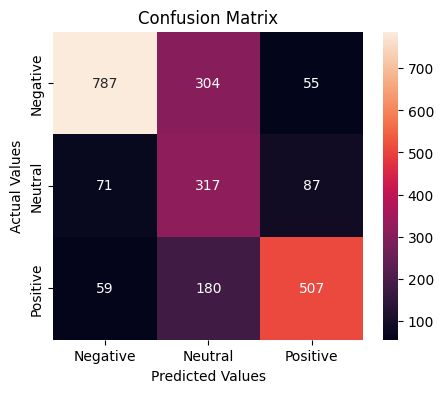

In [66]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(label_values, pred_name_values)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [67]:
val_df.to_csv('train_validation.csv', columns=['text', 'label', 'char_count', 'pred', 'control', 'pred_name'])

## Inference

In [68]:
tokenized_ds['test']['text'][:10]

['christian a. palomino christofher k. chqu carlos novoa chavez fiorella vilchez katherine ardiles podríamos hacer estooo ?  emoji cara llorando fuerte emoji  emoji cara llorando fuerte emoji  emoji cara llorando fuerte emoji  salgamos parfavar...!',
 'la chuecona no pasa nada es gorda no tiene forma mil veces xoana un amor  emoji cara saboreando comida emoji',
 'para pulirla necesita una lija de fierro la más gruesa, o talves se canso de pulir 🤦 emoji tono de piel claro emoji \u200d🤦 emoji tono de piel claro emoji \u200d🤦 emoji tono de piel claro emoji \u200d emoji cara revolviéndose de la risa emoji  emoji cara revolviéndose de la risa emoji  emoji cara revolviéndose de la risa emoji  emoji pulgar hacia arriba emoji  emoji pulgar hacia arriba emoji  emoji pulgar hacia arriba emoji',
 'emoji cara vomitando emoji  emoji cara vomitando emoji  emoji cara vomitando emoji  guacala ese maletero',
 'xabier cañola miñan que hago yo ahí?  emoji cara llorando de risa emoji  emoji cara llorando 

In [69]:
test_df = ds['test'].to_pandas()

## Evaluate the Model Qualitatively (Human Evaluation)

## Evaluate the Model Quantitatively (with F1 Metric)

In [70]:
texts = test_df[0:20]['text']
human_baseline_labels = test_df[0:20]['label']

In [71]:
texts

0                                                                                                                                                             christian a. palomino christofher k. chqu carlos novoa chavez fiorella vilchez katherine ardiles podríamos hacer estooo ? 😭😭😭 salgamos parfavar...!
1                                                                                                                                                                                                                                      la chuecona no pasa nada es gorda no tiene forma mil veces xoana un amor 😋
2                                                                                                                                                                                                           para pulirla necesita una lija de fierro la más gruesa, o talves se canso de pulir 🤦🏻‍️🤦🏻‍️🤦🏻‍️🤣🤣🤣👍👍👍
3                                                                                 

In [72]:
human_baseline_labels

0     1
1     0
2     2
3     0
4     1
5     1
6     1
7     1
8     2
9     1
10    0
11    0
12    0
13    2
14    0
15    2
16    0
17    1
18    2
19    2
Name: label, dtype: int64

In [73]:
def get_prediction(text):
    input_ids = tokenizer(text, return_tensors="pt", max_length=128).input_ids.to('cuda')
    logits = model(input_ids).logits
    probabilities = logits.softmax(dim=-1).tolist()[0]
    return np.argmax(probabilities).flatten()[0]

In [74]:
#original_model_summaries = []
model_classifications = []
for _, text in enumerate(texts):
    model_classifications.append(get_prediction(text))

In [75]:
model_classifications

[1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 1, 1, 1, 2]

## Step by step predictions on dataframe

In [76]:
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.
pred_test_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    text = row["text"]
    encoded_data_test_single = tokenizer.batch_encode_plus([text], 
    # add_special_tokens=config.add_special_tokens, 
    # return_attention_mask=config.return_attention_mask, 
    # pad_to_max_length=config.pad_to_max_length, 
    max_length=128,
    # return_tensors=config.return_tensors
    return_tensors="pt"
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_test_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/1894 [00:00<?, ?it/s]

In [77]:
len(pred_test_final)

1894

In [78]:
# add pred into val_df
test_df["pred"] = pred_test_final

In [79]:
# label to intent mapping
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x)) 

In [80]:
test_df.sample(20)

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count,pred,pred_name
302,q ya vuelta tienes en tu cabezita 🤪,0,Negative,Q ya vuelta tienes en tu cabezita 🤪,q ya vuelta tienes en tu cabezita 🤪,8,9,35,35,0,Negative
137,provecho chinito que rico comes ya me dió hambre ahorita me voy a hacer unos ricos tallarines ️,2,Positive,Provecho chinito que rico comes ya me dió hambre ahorita me voy a hacer unos ricos tallarines ❤️,provecho chinito que rico comes ya me dió hambre ahorita me voy a hacer unos ricos tallarines ️,18,21,95,95,2,Positive
1565,yo soy alla pero no conosco dode bende la papa rellen tan crocante hoye amigo te folto conoser muchos platillos desde bolivia muchos cariños para mi tierra querida huanuco la perri choli😀😀😀,2,Positive,Yo soy alla pero no conosco dode bende la papa rellen tan crocante hoye amigo te folto conoser muchos platillos desde bolivia muchos cariños para mi tierra querida huanuco la perri choli😀😀😀😀,yo soy alla pero no conosco dode bende la papa rellen tan crocante hoye amigo te folto conoser muchos platillos desde bolivia muchos cariños para mi tierra querida huanuco la perri choli😀😀😀,32,46,191,191,2,Positive
403,siempre poner jugadores de nombre que no hacen ni desacen ⭐️necesitamos un dt. como nunes de brazil el si arriesga con jovenes promesas ⚽️🏆⭐️,0,Negative,Siempre poner jugadores de Nombre que no hacen ni desacen ⭐️Necesitamos un DT. Como NUNES de BRAZIL el si arriesga con Jovenes Promesas ⚽️🏆⭐️,siempre poner jugadores de nombre que no hacen ni desacen ⭐️necesitamos un dt como nunes de brazil el si arriesga con jovenes promesas ⚽️🏆⭐️,24,29,142,142,1,Neutral
120,gordito tu trabajo es hueveo no tiene riesgo 😂😂😂,0,Negative,Gordito tu trabajo es hueveo No tiene riesgo 😂😂😂,gordito tu trabajo es hueveo no tiene riesgo 😂😂😂,9,11,48,48,2,Positive
702,"ya comimos ayer arroz, huevo, platanitod y su arto rocoto con huacatay buenazooo. solo que no tomé foto 😔",2,Positive,"Ya comimos ayer arroz, huevo, platanitod y su arto rocoto con huacatay Buenazooooooooo. Solo que no tomé foto 😔",ya comimos ayer arroz huevo platanitod y su arto rocoto con huacatay buenazooo solo que no tomé foto 😔,19,31,105,105,1,Neutral
192,nicola me llega ala huaraca 😅😅😅,0,Negative,Nicola me llega ala huaraca 😅😅😅😅😅😅😅,nicola me llega ala huaraca 😅😅😅,6,9,31,31,0,Negative
589,hahaha no sé xk me hizo recordar la palabra mongol 🤔😅 ahora si vamos felix,1,Neutral,Hahaha no sé xk me hizo recordar la palabra mongol 🤔😅 ahora si vamos Felix,hahaha no sé xk me hizo recordar la palabra mongol 🤔😅 ahora si vamos felix,15,16,74,74,1,Neutral
1135,buen video causita me hiciste la tarde 🤣🤣... me senti identificado xd :v,2,Positive,Buen video causita me hiciste la tarde 🤣🤣... me senti identificado xD :v,buen video causita me hiciste la tarde 🤣🤣 me senti identificado xd v,13,14,72,72,2,Positive
1457,"woww super cool, que chevere del perú para el mundo directito al travel and living channel 😁, felicitaciones por el primer lugar 🎉!! disfruto mucho mirando los videos de tu programa y lo super fresco de la conduccion",2,Positive,"Woww super cool, que chevere del Perú para el mundo directito al travel and living channel 😁, felicitaciones por el primer lugar 🎉!! Disfruto mucho mirando los videos de tu programa y lo super fresco de la conduccion",woww super cool que chevere del perú para el mundo directito al travel and living channel 😁 felicitaciones por el primer lugar 🎉 disfruto mucho mirando los videos de tu programa y lo super fresco de la conduccion,38,43,216,216,2,Positive


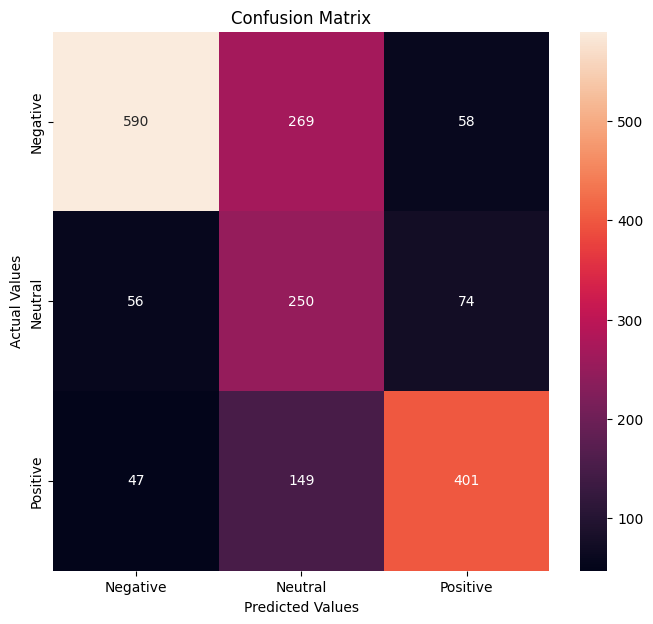

<Figure size 640x480 with 0 Axes>

In [81]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_name_values = test_df.pred_name.values
label_values = test_df.label_name.values
cm = confusion_matrix(label_values, pred_name_values)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(8,7))
sns.heatmap(cm_df, annot=True,fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

plt.savefig('cm_test_predictions.png')

In [82]:
test_df.sample(10)

,text,label,label_name,text_original,tokenized_text,sent_token_length,sent_bert_token_length,char_count,Character Count,pred,pred_name
94,kelly jaja la trica la bica!!! 😂😂😂 quiero volver... (mentira no quiero) 😅 cuando consigues trabajo 😂😂😂,2,Positive,Kelly jajajajajaja la trica la bica!!! 😂😂😂 quiero volver... (mentira no quiero) 😅 cuando consigues trabajo 😂😂😂,kelly jaja la trica la bica 😂😂😂 quiero volver mentira no quiero 😅 cuando consigues trabajo 😂😂😂,17,26,102,102,1,Neutral
504,"bien merecido manolo , que sigan los viajes 😁😁 ojala y algún día también manden a los televidentes a uno de esos tantos viajesitos 😂😂😂",2,Positive,"Bien merecido Manolo , que sigan los viajes 😁😁 ojala y algún día también manden a los televidentes a uno de esos tantos viajesitos 😂😂😂",bien merecido manolo que sigan los viajes 😁😁 ojala y algún día también manden a los televidentes a uno de esos tantos viajesitos 😂😂😂,25,29,135,135,2,Positive
1370,le está quitando el puesto a maduro 😂,0,Negative,Le está quitando el puesto a Maduro 😂,le está quitando el puesto a maduro 😂,8,8,37,37,0,Negative
1865,en las pichangas se miente mucho,0,Negative,En las pichangas se miente mucho,en las pichangas se miente mucho,6,8,32,32,0,Negative
756,ubieses regalado a todos esos cañonazos. 😅,0,Negative,Ubieses regalado a todos esos cañonazos. 😅,ubieses regalado a todos esos cañonazos 😅,7,11,42,42,0,Negative
1175,roshita julissa lo que les decía de la canción 🙈,1,Neutral,Roshita Julissa lo que les decía de la canción 🙈,roshita julissa lo que les decía de la canción 🙈,10,14,49,49,1,Neutral
605,"no necesitaba sacar la chaveta, se lo juro",1,Neutral,"No necesitaba sacar la chaveta, se lo juro",no necesitaba sacar la chaveta se lo juro,8,10,42,42,1,Neutral
1390,grabame la cuca jaja esa cochina marginal tan fiera no nos representa dejenlos pegos para que aprendan claro me respetan alos paisanos que trabajan para bien y su familia siempre lo edicho si eres una plaga que no trabajas en venezuela que vas acer para otro país a ponernos en mal alos que si sa...,0,Negative,Grabame la Cuca jaja esa cochina marginal tan fiera no nos representa dejenlos pegos para que aprendan claro me respetan alos paisanos que trabajan para bien y su familia siempre lo edicho si eres una plaga que no trabajas en Venezuela que vas Acer para otro país a ponernos en mal alos que si sa...,grabame la cuca jaja esa cochina marginal tan fiera no nos representa dejenlos pegos para que aprendan claro me respetan alos paisanos que trabajan para bien y su familia siempre lo edicho si eres una plaga que no trabajas en venezuela que vas acer para otro país a ponernos en mal alos que si sa...,74,82,398,398,0,Negative
19,"aqui todo explicadito sobre la gran labor de hashtag interartis estoy mas que contento y seguro con ellos, gracias emilio montero, cecilia tosso y todo los grandes profesionales que estan detras de la preocupacion de nuestro trabajo 🎥 📽️ 🎭💚🌟",2,Positive,"Aqui todo explicadito sobre la gran labor de #interartis estoy mas que contento y seguro con ellos, gracias Emilio Montero, Cecilia Tosso y todo los grandes profesionales que estan detras de la preocupacion de nuestro trabajo 🎥 📽️ 🎭💚🌟",aqui todo explicadito sobre la gran labor de hashtag interartis estoy mas que contento y seguro con ellos gracias emilio montero cecilia tosso y todo los grandes profesionales que estan detras de la preocupacion de nuestro trabajo 🎥 📽️ 🎭💚🌟,40,48,241,241,2,Positive
351,chino risas pa que llevas a tus maleteros 🤪😛😛,0,Negative,chino risas pa que llevas a tus maleteros 🤪😛😛,chino risas pa que llevas a tus maleteros 🤪😛😛,9,10,45,45,2,Positive


In [83]:
test_df.to_csv('test_inference.csv', columns=['text', 'label','label_name', 'char_count', 'pred', 'pred_name'])

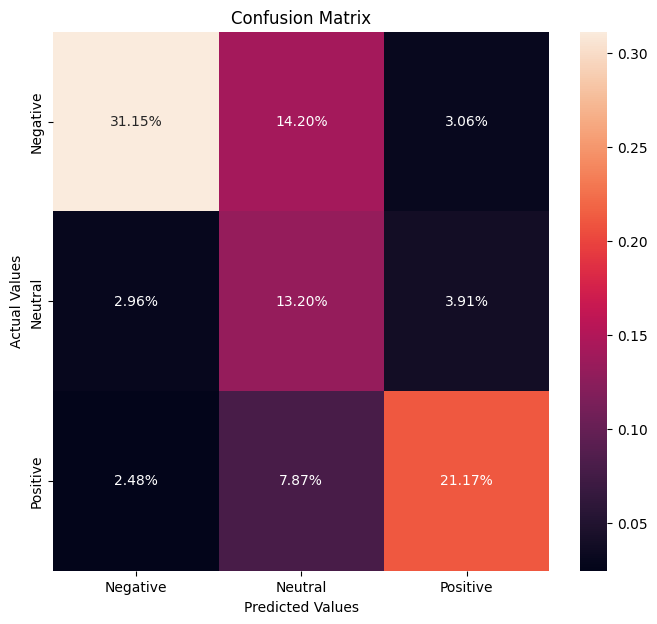

In [84]:
cm = confusion_matrix(label_values, pred_name_values)
cm_df = pd.DataFrame(cm/np.sum(cm),
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(8,7))
sns.heatmap(cm_df, annot=True, fmt=".2%")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig('cm_test_predictions_percentage.png')
plt.show()